In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from matplotlib import pyplot as plt

from utils.basic_utils import *
from utils.fundamental import chain_outlier, get_focus_tickers
from utils.pricing import load_px_close, get_return_intervals 
from utils.pricing import dummy_col, discret_rets, sample_wgts
from utils.pricing import px_mom_feats, px_mom_co_feats_light 
from utils.pricing import eq_wgt_indices, to_index_form, rename_col

pd.options.display.float_format = '{:,.2f}'.format

Loading utils/config.json


In [2]:
import time, os, sys
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.externals import joblib

### Context data

In [3]:
bench = '^GSPC'
y_col = 'fwdReturn'
tickers = excl(config['companies'], [])

context = {
    'tickers': tickers,
    'ml_path': '../ML/',
    'model_name': 'micro_NN.pkl',
    'tmp_path': '../tmp/',
    'ds_name': 'co-technicals-ds',
    'px_close': 'universe-px-ds',
    'trained_cols': 'micro_NN_train_cols.npy',
    'look_ahead': 120,
    'look_back': 252,
    'smooth_window': 20,    
    'load_ds': True,
    'scale': True,
    'test_size': .20,
    'verbose': True,
    's3_path': 'recommend/micro_ML/',
    'neuron_mult': 5,
    'hidden_layers': 3,
    'max_iter': 20,    
}

In [22]:
# for notebook only
ec2_IP = '54.201.151.162'
remote_path = config['remote_path']
px_close_ds = context['px_close']
tmp_path = context['tmp_path']
!scp -i ~vveiga/.ssh/qc_infra.pem ubuntu@{ec2_IP}:{remote_path}/tmp/{px_close_ds} {tmp_path}{px_close_ds}

universe-px-ds                                100%   18MB   6.6MB/s   00:02    


In [8]:
px_close = load_px_close(
    context['tmp_path'], context['px_close'], context['load_ds']).drop_duplicates()
print('px_close.info()', px_close.info())

prices = px_close.dropna(subset=[bench])[tickers]
look_ahead = context['look_ahead']
cut_range = get_return_intervals(prices, look_ahead, tresholds=[0.25, 0.75])
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
f'Return intervals {cut_range}'

# latest quotes, profile, and industries
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3
print(f'Target date: {tgt_date}')

quotes = load_csvs('quote_consol', [tgt_date])
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

Target date: 2019-05-03
Loading file quote/csv/2019-05-03
Loading file summary-categories/assetProfile


In [10]:
# Smaller subset for testing
tgt_sectors = [
#     'Technology', 
    'Communication Services', 
#     'Healthcare', 
#     'Consumer Cyclical', 
#     'Consumer Defensive', 
#     'Industrials'
]
size_df = get_focus_tickers(quotes, profile, tgt_sectors)
context['tickers'] = list(size_df.index)

### Final

In [11]:
def create_pre_process_ds(context):
    
    tickers = context['tickers']
    sectors = profile.loc[profile.symbol.isin(tickers)].sector.unique()
    industries = profile.loc[profile.symbol.isin(tickers)].industry.unique()
    print(f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}')
    
    indices_df = pd.concat(
        [eq_wgt_indices(profile, px_close, 'sector', sectors, subset=tickers),
        eq_wgt_indices(profile, px_close, 'industry', industries, subset=tickers),
        to_index_form(px_close[bench], bench)], 
        axis=1).drop_duplicates()
    
    # create price momentum features
    tmp_path = context['tmp_path']
    ds_name = context['ds_name']

    super_list = []
    for i, ticker in tqdm(enumerate(tickers)):
        try:
            close = px_close[ticker].dropna()
            ft_df = px_mom_feats(close, ticker, incl_name=False)
            if ticker in profile.symbol.unique():
                top_groups = tuple([bench, profile.loc[ticker, 'sector']])
                co = px_mom_co_feats_light(close, indices_df, top_groups)
                ft_df = pd.concat([ft_df, co.loc[ft_df.index, :]], axis=1)
                super_list.append(ft_df.copy())
            else: print(ticker, 'missing profile, skipping')
        except Exception as e: 
            print("Exception: {0} {1}".format(ticker, e))

    joined_df = pd.concat(super_list, axis=0)
    joined_df = chain_outlier(joined_df, None)
        
    # basic impute and scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(joined_df)
    joined_df.loc[:, num_cols] = joined_df[num_cols].replace([np.inf, -np.inf, np.nan], 0)
    if scale_on: joined_df.loc[:, num_cols] = scaler.fit_transform(joined_df[num_cols])

    # add categoricals
    joined_df = dummy_col(joined_df, 'sector', shorten=True)
    
    return joined_df

In [12]:
def train_ds(context):
    
    verbose = context['verbose']
    ml_path, model_name = context['ml_path'], context['model_name']
    trained_cols = context['trained_cols']    
    look_ahead, look_back, smooth_window = context['look_ahead'], context['look_back'], context['smooth_window']
    f'{look_ahead} days, {look_back} days, {smooth_window} days'

    joined_df = create_pre_process_ds(context)

    # if we want to limit training set
    # index = joined_df.sort_index().index.unique()[-look_back:]
    # joined_df = joined_df.loc[index, :]
    # joined_df.shape

    # calculation of forward returns
    Y = px_close.loc[:, tickers].pct_change(look_ahead).shift(-look_ahead)
    # Y = Y.rolling(smooth_window).mean() # smooth by the same length
    Y = Y[~(Y.isna().all(1))]
    Y = Y.loc[joined_df.index.unique(), :]

    # reshapes to include symbol in index in additional to date
    Y_df = Y.loc[joined_df.index.unique().sortlevel()[0], tickers]
    Y_df = Y_df.stack().to_frame().rename(columns={0: y_col})
    # somwhat repetitive with steps above but performs faster
    Y_df.index.set_names(['storeDate', 'symbol'], inplace=True)
    print('Y_df.shape', Y_df.shape)

    # re-index processed df on storeDate and symbol to have similar indices
    joined_df.index.set_names('storeDate', inplace=True)
    joined_df.set_index(['symbol'], append=True, inplace=True)
    print('joined_df.shape', joined_df.shape)

    # add Y values to processed df fast without having to loop
    joined_df.loc[:, y_col] = Y_df.loc[joined_df.index, y_col]

    # joined_df.loc[(slice(None), 'AAPL'), y_col].plot() # visualize smoothing
    # joined_df.groupby('symbol')[y_col].mean().sort_values() # rank long-term mean performance

    # discretize Y-variable
    joined_df.dropna(subset=[y_col], inplace=True)
    joined_df[y_col] = discret_rets(joined_df[y_col], cut_range, fwd_ret_labels)
    print('joined_df.shape', joined_df.shape)
    print(sample_wgts(joined_df[y_col]))

    joined_df.dropna(subset=[y_col], inplace=True)
    joined_df.loc[:, y_col] = joined_df[y_col].astype(str)

    days = len(joined_df.index.levels[0].unique())
    print(f'Training for {days} dates, {round(days/252, 1)} years')

    # joined_df.loc[(slice(None), 'TAL'), y_col].value_counts() # look at a specific security distribution
    train_df = joined_df.reset_index(drop=True)
    train_df.shape

    # create training and test sets
    X, y = train_df.drop(columns=y_col), train_df[y_col]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        break # just one split

    # skf = StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
    # for train_index, test_index in skf.split(X, y):
    #     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #     break

    # MLPClassifier
    neuron_mult = context['neuron_mult']
    max_iter = context['max_iter']
    neurons = X_train.shape[1] * neuron_mult
    hidden_layers = tuple([neurons for x in range(context['hidden_layers'])])

    mlp_params = {
        'solver': 'adam', 'max_iter': max_iter, #reduced from 600 for testing
        'hidden_layer_sizes': hidden_layers,
        'n_iter_no_change': 10, 'verbose': True, 'random_state': None, }
    clf = MLPClassifier(**mlp_params)
    print(clf)
    clf.fit(X_train, y_train)
    print(f'Train {clf.score(X_train, y_train)}, Test {clf.score(X_test, y_test)}')

    # save training columns
    np.save(ml_path + trained_cols, X_train.columns) # save feature order
    print(f'X_train.shape {X_train.shape}, columns: {list(X_train.columns)}')
    print('Saved: ', ml_path + trained_cols)

    # save model
    os.makedirs(ml_path, exist_ok=True)
    fname = ml_path + model_name
    joblib.dump(clf, fname)
    print('Saved ', fname)

In [13]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']

    joined_df = create_pre_process_ds(context)
    pred_X = joined_df.loc[joined_df.sort_index().index[-1], :]
    print('pred_X.shape', pred_X.shape)
    
    # ensure prediction dataset is consistent with trained model
    train_cols = np.load(ml_path + trained_cols) # save feature order
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        pred_X = pd.concat([pred_X, pd.DataFrame(columns=missing_cols)], axis=1)
        pred_X[missing_cols] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    fname = ml_path + model_name
    clf = joblib.load(fname) # load latest models
    print('Loaded', fname)

    preds = clf.predict(pred_X[sorted_cols].iloc[:, :-1])
    pred_class = np.array([fwd_ret_labels.index(x) for x in preds])
    pred_df['pred_class'] = pred_class
    pred_df['pred_label'] = preds
    probs = clf.predict_proba(pred_X[sorted_cols].iloc[:, :-1])
    pred_prob = np.argmax(probs, axis=1)
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=clf.classes_)
    pred_df = pd.concat([pred_df, prob_df[fwd_ret_labels]], axis=1)
    pred_df.index.name = 'pred_date'

    # store in S3
    s3_path = context['s3_path']
    s3_df = pred_df.reset_index(drop=False)
    rename_col(s3_df, 'index', 'pred_date')
    csv_store(s3_df, s3_path, csv_ext.format(tgt_date))
            
    return pred_df

#### Train

In [9]:
%time train_ds(context)

0it [00:00, ?it/s]

Sectors: 1, Industries: 10


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
30it [00:02, 13.90it/s]
/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Y_df.shape (611263, 1)
joined_df.shape (89784, 18)


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


joined_df.shape (86949, 19)
neutral   0.47
bull      0.19
long      0.16
bear      0.11
short     0.07
Name: fwdReturn, dtype: float64
Training for 3865 dates, 15.3 years
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(90, 90, 90), learning_rate='constant',
       learning_rate_init=0.001, max_iter=20, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)
Iteration 1, loss = 1.34492664
Iteration 2, loss = 1.29112607
Iteration 3, loss = 1.24865591
Iteration 4, loss = 1.21597844
Iteration 5, loss = 1.19046896
Iteration 6, loss = 1.16384316
Iteration 7, loss = 1.14298966
Iteration 8, loss = 1.12495029
Iteration 9, loss = 1.10649565
Iteration 10, loss = 1.08784989
Iteration 11, loss = 1.07269442
Iteration 12, loss = 1.0574

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Train 0.6337785189551316, Test 0.6040253018976424
X_train.shape (69559, 18), columns: ['PctChg1Stds', 'PctMA50', 'PctMA200', 'RollVol30', 'PctChg20', 'PctChg60', 'PctChg120', 'Pct52WkH', 'Pct52WkL', 'rsBench20', 'rsSect20', 'rsBench60', 'rsSect60', 'rsBench120', 'rsSect120', 'benchPctChgStds', 'sectPctChgStds', '^TECH']
Saved:  ../ML/micro_NN_train_cols.npy
Saved  ../ML/micro_NN.pkl
CPU times: user 1min 2s, sys: 9.61 s, total: 1min 12s
Wall time: 14.5 s


#### Predict

In [83]:
# !ls -lht {ml_path}

In [14]:
# predict for all
%time pred_df = predict_ds(context)

0it [00:00, ?it/s]

Sectors: 1, Industries: 2


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
29it [00:02, 12.31it/s]


pred_X.shape (29, 19)
Warning missing columns: ['^CONS_CYCL', '^CONS_DEFE', '^HEAL', '^INDU', '^TECH']


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


ValueError: Shape of passed values is (29, 24), indices imply (1, 24)

#### Store / Read S3

In [15]:
s3_path = context['s3_path']

In [16]:
# read from S3
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{tgt_date}'), 
    index_col='pred_date', parse_dates=True)

#### Visualize

In [21]:
pred_df

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2019-05-01,AMT,3,long,1.00,0.00,0.00,0.00,1.00,0.00
2019-05-01,AMX,4,bull,0.98,0.00,0.00,0.00,0.02,0.98
2019-05-01,BT,2,neutral,1.00,0.00,0.00,1.00,0.00,0.00
2019-05-01,CABO,2,neutral,1.00,0.00,0.00,1.00,0.00,0.00
2019-05-01,CCOI,1,short,0.63,0.00,0.63,0.37,0.00,0.00
2019-05-01,CHL,4,bull,0.98,0.00,0.00,0.01,0.00,0.98
2019-05-01,CHTR,2,neutral,0.99,0.00,0.01,0.99,0.01,0.00
2019-05-01,CHU,2,neutral,1.00,0.00,0.00,1.00,0.00,0.00
2019-05-01,CMCSA,3,long,0.99,0.00,0.00,0.01,0.99,0.00


In [18]:
# recommendation distribution
pd.value_counts(pred_df.pred_label)

neutral    14
long        5
bull        5
short       3
bear        2
Name: pred_label, dtype: int64

In [20]:
# top 3 picks by label
label_mask = pred_df.pred_label.isin(['bear', 'short', 'long', 'bull'])
pred_df.loc[label_mask]\
    .sort_values(by='confidence', ascending=False)\
    .groupby(by='pred_label').head(20)\
    .sort_values(by='pred_label')

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2019-05-01,VG,0,bear,0.80,0.80,0.00,0.19,0.00,0.00
2019-05-01,VOD,0,bear,0.80,0.80,0.00,0.20,0.00,0.00
2019-05-01,VIV,4,bull,0.99,0.00,0.00,0.00,0.01,0.99
2019-05-01,CHL,4,bull,0.98,0.00,0.00,0.01,0.00,0.98
2019-05-01,AMX,4,bull,0.98,0.00,0.00,0.00,0.02,0.98
2019-05-01,TKC,4,bull,0.94,0.00,0.06,0.00,0.00,0.94
2019-05-01,DISH,4,bull,0.93,0.00,0.00,0.06,0.01,0.93
2019-05-01,IDCC,3,long,1.00,0.00,0.00,0.00,1.00,0.00
2019-05-01,AMT,3,long,1.00,0.00,0.00,0.00,1.00,0.00


### Other experiments

In [122]:
tgt_sectors = [
    'Technology', 'Communication Services', 
    'Healthcare', 'Consumer Cyclical', 'Consumer Defensive', 'Industrials']
size_df = get_focus_tickers(quotes, profile, tgt_sectors)
size_df.groupby('industry').sum()['marketCap'].sort_values()

industry
Engineering & Construction              83.82
Packaging & Containers                  90.67
Medical Care                            93.75
Scientific & Technical Instruments     107.24
Electronic Components                  124.90
Leisure                                252.71
Biotechnology                          286.58
Medical Instruments & Supplies         287.91
Restaurants                            344.67
Business Services                      386.81
Communication Equipment                420.76
Information Technology Services        430.11
Diagnostics & Research                 447.77
Medical Devices                        500.25
Media - Diversified                    522.33
Packaged Foods                         569.99
Household & Personal Products          648.31
Aerospace & Defense                    681.69
Diversified Industrials                795.47
Semiconductors                       1,195.61
Telecom Services                     1,263.18
Software - Infrastructure

In [123]:
size_df.groupby(['size', 'sector', ]).count()['marketCap']
size_df.groupby('size').count()['marketCap']

size
micro      0
small     32
mid      229
large    237
mega      10
Name: marketCap, dtype: int64

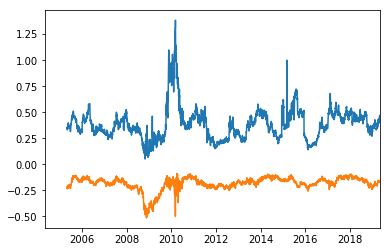

In [94]:
# Average increase and decrease over a give time period
prices = px_close.dropna(subset=[bench])[tickers]
excl_tickers = list(prices.iloc[-1].isna().loc[prices.iloc[-1].isna().values].index)
prices = prices[excl(prices.columns, excl_tickers)]

look_back = context['look_back']
prices.pct_change(look_back).where(prices.pct_change(look_back) > 0).mean(1).plot()
prices.pct_change(look_back).where(prices.pct_change(look_back) < 0).mean(1).plot()

In [95]:
get_return_intervals(prices, 120, tresholds=[0.25, 0.75])

(-inf,
 -0.18970860540866852,
 -0.12610292434692383,
 0.18030300736427307,
 0.3123534917831421,
 inf)

#### Date and minute based time analysis

In [ ]:
freq = '1d'

In [ ]:
# s1, s2 = '1810.HK', 'AAPL'
group_pricing = pd.DataFrame()
df1 = get_symbol_pricing(s1, freq, ['close'])
df2 = get_symbol_pricing(s2, freq, ['close'])
group_pricing = pd.DataFrame(df1)
# group_pricing.loc[:, s2] = df2
group_pricing = pd.concat([group_pricing, df2], axis=1)
group_pricing.describe()
# group_pricing

In [ ]:
path = config['pricing_path'].format(freq)
data_dict = json_load(path + json_ext.format(ticker))

tz = data_dict['meta']['exchangeTimezoneName']
df = build_px_struct(data_dict, freq)

adjClose = data_dict['indicators']['adjclose'][0] if 'adjclose' in  data_dict['indicators'] else 0
close = data_dict['indicators']['quote'][0]
data_dict.keys(), data_dict['indicators'].keys()

In [ ]:
df.index.date

In [ ]:
dates = pd.to_datetime(
        data_dict['timestamp'], 
        unit='s', infer_datetime_format=True)
# dates = dates.astype(f'datetime64[ns, {tz}]')
# dates.tz_convert('America/New_York')
# dates = dates.tz_localize('America/New_York')
dates.floor('d' if freq == '1d' else 'min')

In [ ]:
df.tail(5)

In [ ]:
freq = '1d'

In [ ]:
%time px_close = get_mults_pricing(symbols_list[:10], freq);

In [ ]:
# [px_close[x].dropna().tail() for x in px_close.columns]
px_close.describe()
# px_close.tail()

In [ ]:
f'Ticker: {ticker}'

In [ ]:
px = get_symbol_pricing(ticker, freq)
px.close.tail()

#### Old code

In [ ]:
# test distribution of Y variable
tickers = list(mu.sample_sector_tickers(eqty_symbols, profile, sectors, 50).index)
context['grid_search'] = False
context['tickers'] = tickers
context['train_model'] = True

df_large = create_ds(context)

df = df_large.copy()
df.dropna(subset=[y_col], inplace=True)
df[y_col] = discret_rets(df[y_col], cut_range, fwd_ret_labels)
df.dropna(subset=[y_col], inplace=True) # no nas in y_col
df[y_col] = df[y_col].astype(str) # class as string
sample_wgts(df[y_col])

pred_X, X_traxin, X_test, y_train, y_test = pre_process_ds(df_large, context)
pd.value_counts(discret_rets(df_large.fwdReturn, cut_range, fwd_ret_labels)).sum()
pd.value_counts(pd.concat([y_train, y_test], axis=0)).sum()

In [ ]:
# Test cumulative drawdowns and pulls
n = 100
r_w = np.random.randn(n).cumsum() + 100
l_dd, h_dd, l_p, h_p = max_draw_pull(r_w)

plt.plot(r_w)
plt.plot(
    [l_dd, h_dd], 
    [r_w[l_dd], r_w[h_dd],], 
    'o', color='Red', markersize=10)
plt.plot(
    [l_p, h_p], 
    [r_w[l_p], r_w[h_p]], 
    'o', color='Green', markersize=10)

In [ ]:
# Retrieves historical pricing
secpx = get_symbol_pricing(symbol, freq)
secpx.set_index(secpx.index.astype(np.datetime64), inplace=True)

In [ ]:
fwd_ss_ret = lambda x, df, arr: df.loc[[y for y in arr[x-1] if y in df.index.tolist()]].mean()

In [ ]:
# seasonality analysis
ss_df = closepx.pct_change().resample('M').sum().to_frame()
ss_df['year'], ss_df['month'] = ss_df.index.year, ss_df.index.month
ss_df = ss_df.pivot_table(index='year', columns='month').mean()
ss_pos = [(x, (x+1) if not (x+1) // 12 else 0, 
     x+2 if not (x+2) // 12 else x - 10) for x in range(12)]

# [fwd_ss_ret(x+1, ss_df['close'], ss_pos) for x in range(12)] # test

In [ ]:
# apply seasonality, mean return of curr month plus next two
secpx['month'] = secpx.index.month
secpx['fwdSSRet'] = secpx.loc[:].month.apply(
    fwd_ss_ret, args=(ss_df['close'], ss_pos,))

In [ ]:
secpx.columns # all columns

In [ ]:
# normalized columns for ML training, still has outliers
ml_ds_cols = secpx.describe().loc['50%'][secpx.describe().loc['50%'] < 5].index.tolist()
ml_ds_cols

In [ ]:
# prepare ML dataset
ml_ds = secpx[ml_ds_cols].copy()

class_cols = ['fwdChg1w', 'fwdChg1m', 'fwdChg3m']
cut_range = [-1, -0.05, .0, .02, .09, 1.]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

for c in class_cols: ml_ds[c] = pd.cut(secpx[c], cut_range, labels=fwd_ret_labels)
ml_ds.info()

In [ ]:
# drop the predicting class with most nas
ml_ds.dropna(inplace=True)
ml_ds.info()

In [ ]:
ml_ds.hist(figsize=(15,15));

In [ ]:
ml_ds.to_csv(csv_ext.format('co_price_mom_ds'), index=False)